In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
from trackml.dataset import load_event
import seaborn as sns
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

In [4]:
path2data = '/home/alepfu/Desktop/dataset/train_100_events/'
event_id = 'event000001000'
hits, cells, particles, truth = load_event(path2data + event_id)
data = pd.merge(pd.merge(truth, pd.DataFrame(hits), on = ['hit_id']), pd.DataFrame(particles), on = ['particle_id']).loc[:,['hit_id', 'particle_id', 'x', 'y', 'z','volume_id','layer_id']]
data['r'] = data.apply(lambda h: np.sqrt(h['x']**2 + h['y']**2), axis=1)
data.head(1)

,hit_id,particle_id,x,y,z,volume_id,layer_id,r
0,2,22525763437723648,-55.336102,0.635342,-1502.5,7,2,55.339749


In [22]:
particle_ids = pd.DataFrame(data['particle_id'].unique())

seqs_collect = ['8_13_17']

particle_ids_collect = []

for p in particle_ids.values:
    t = data[data['particle_id'] == p[0]]
    seq = map(str, np.sort(t['volume_id'].unique()))
    seq_str = "_".join(seq)
    if seq_str in seqs_collect:
        particle_ids_collect.append(p[0])


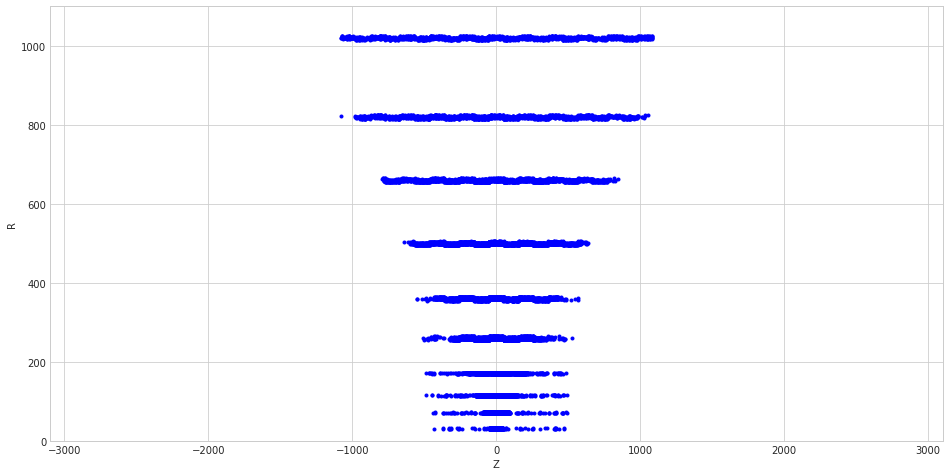

In [23]:
plt.figure(figsize=(16,8))        
        
for p in particle_ids_collect:
    t = data[data['particle_id'] == p]
    plt.plot(t['z'], t['r'], '.', color='b')

plt.xlim((-3100,3100))
plt.ylim((0,1100))
plt.xlabel("Z")
plt.ylabel("R")
plt.show()

## RANSAC for a sample of same sequence tracks

In [47]:
from sklearn import linear_model

sample_particle_ids = pd.DataFrame(particle_ids_collect).sample(50).values.ravel()

df_collect = data[data['particle_id'].isin(sample_particle_ids)]

X = df_collect['z'].values.reshape(-1, 1)
y = df_collect['r'].values.ravel()

ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

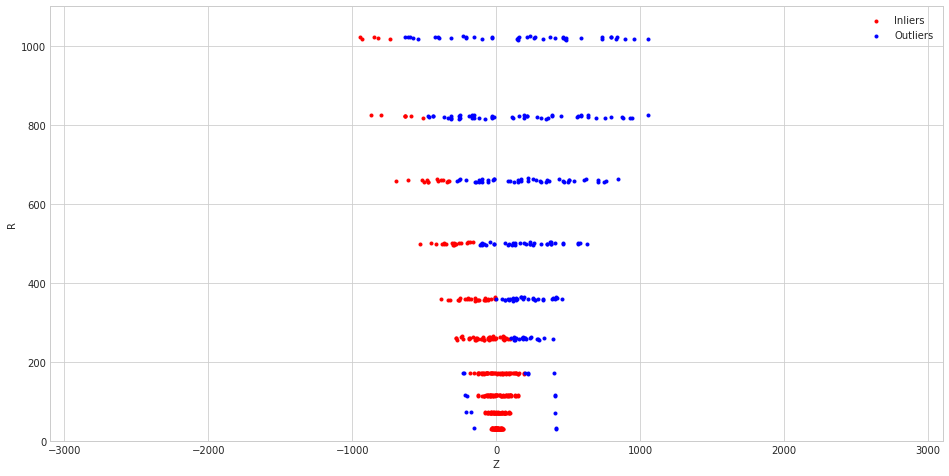

In [48]:
plt.figure(figsize=(16,8))  

plt.scatter(X[inlier_mask], y[inlier_mask], color='r', marker='.',label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='b', marker='.',label='Outliers')
plt.legend()
plt.xlim((-3100,3100))
plt.ylim((0,1100))
plt.xlabel("Z")
plt.ylabel("R")
plt.show()

# TODO experiment with residual_threshold of ransac model to get fewer inliers, then get the points close to the ransac line

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py

In [ ]:


# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_X)